In [54]:
from pygama.dsp.processors import gaussian_filter1d, moving_windows, get_multi_local_extrema, peak_snr_threshold, multi_a_filter
from pygama.dsp.processors.histogram import histogram, histogram_stats
from pygama.lgdo.lh5_store import LH5Iterator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12

file='/mnt/atlas01/projects/legend/data/com/raw/2022-04-13-sipm-test/run007/c/20220420-073717-m6-muon-amajl4-mmaj2-es2000.lh5'
dsp_config='/home/ge35miw/pygama/tests/dsp/configs/sipm-dsp-config.json'

In [114]:
#Taking one waveform data as an example
for wf,_,_ in LH5Iterator(file, group='ch001/raw/waveform', buffer_len=1):
    wf_in=wf.values.nda[0]
    t=np.linspace(0,wf.dt.nda[0]*len(wf_in), len(wf_in))
    break

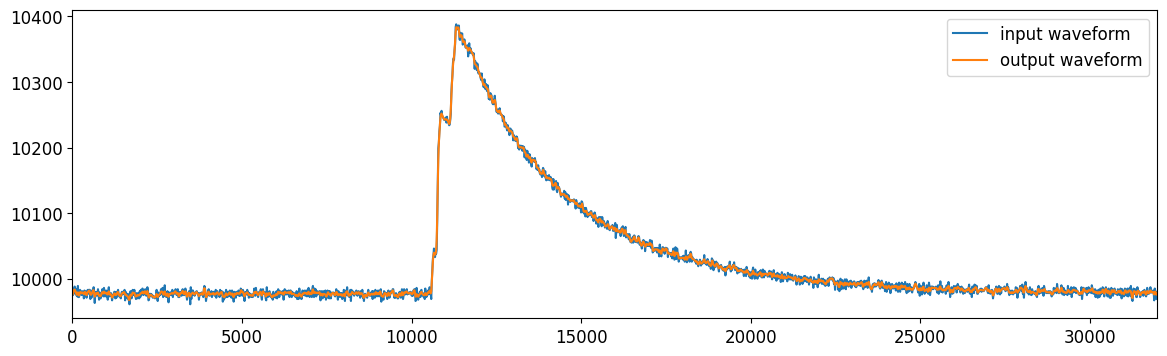

In [115]:
#Performing convolution with a gaussian
wf_out=np.zeros(len(wf_in))
gaussian_filter1d(1,4.0)(wf_in,wf_out)
plt.plot(t,wf_in, label='input waveform')
plt.plot(t,wf_out, label='output waveform')
plt.xlim(0,max(t))
plt.legend()

(80.04002001000501, 32000.0)

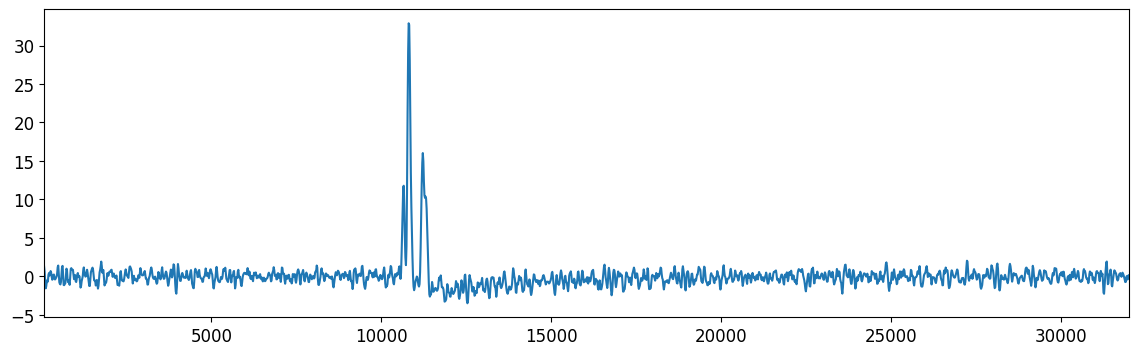

In [131]:
#Calculating the derivatives and avaraging them across 5 samples
curr=np.zeros(len(wf_out)-5)
moving_windows.avg_current(wf_out, 5, curr)
plt.plot(t[5:], curr)
plt.xlim(min(t[5:]), max(t[5:]))

(array([ 6.,  3., 13., ...,  0.,  0.,  2.]),
 array([-3.4994914 , -3.13554292, -2.77159444, ..., 32.16745994,
        32.53140842, 32.8953569 ]),
 <BarContainer object of 100 artists>)

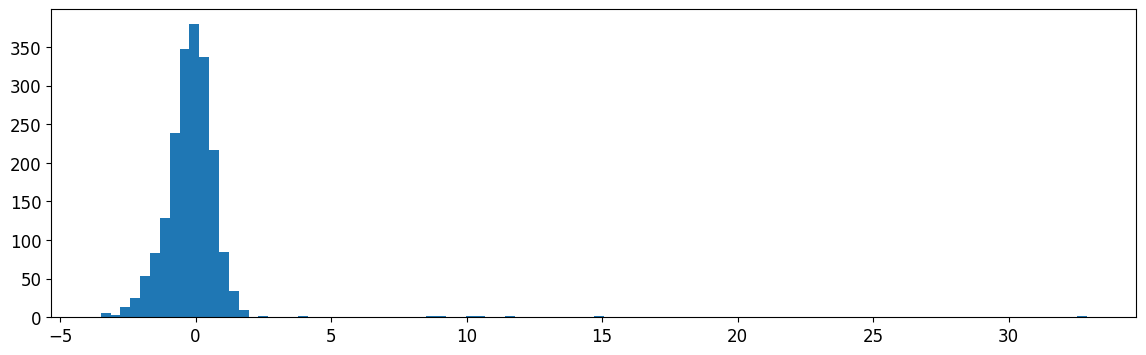

In [132]:
#creating histogram with 100 bins
hist_weights=np.zeros(100)
hist_borders=np.zeros(101)
histogram(curr, hist_weights, hist_borders)
plt.hist(curr, 100)

In [147]:
#Full width half maximum of the histogram
idx_out_c=np.zeros(1) #index of the global max
max_out=np.zeros(1) #left bin edge
fwhm=np.zeros(1)

histogram_stats(hist_weights, hist_borders, idx_out_c, max_out, fwhm, np.nan)
print(f"idx_out_c: {idx_out_c.astype(np.int8)[0]}, max_out: {max_out[0]}, fwhm: {fwhm[0]}")

idx_out_c: 9, max_out: -0.22395505602600707, fwhm: 1.0918454492468848


In [151]:
#Finding local maxima and minima
vt_max_candidate=np.zeros(20)
vt_min=np.zeros(20)
n_max=np.zeros(1)
n_min=np.zeros(1)
flag=np.zeros(1)

get_multi_local_extrema(curr, 5, 3*fwhm[0], 0, vt_max_candidate, vt_min, n_max, n_min, flag)
print(f'maximum candidate: {vt_max_candidate}, n_max: {n_max.astype(np.int8)[0]},\nminumum: {vt_min}, n_min: {n_min.astype(np.int8)[0]}, flag: {flag.astype(np.int8)[0]}')

maximum candidate: [661. 696.  nan ...  nan  nan  nan], n_max: 2,
minumum: [680. 778.  nan ...  nan  nan  nan], n_min: 2, flag: 0


In [152]:
#Calculating the start of the signal (local minima around vt_max_candidate)
trigger_pos=np.zeros(20) #indices of the local minima
no_out=np.zeros(1) #number of non-nan entries in trigger_pos

peak_snr_threshold(curr_diff, vt_max_candidate, 0.8, 10, trigger_pos, no_out)
print(f'trigger_pos: {trigger_pos}, no_out: {no_out.astype(np.int8)[0]}')

trigger_pos: [661. 696.  nan ...  nan  nan  nan], no_out: 2


In [143]:
#Estimating the energies (Finding the maximums of curr and return the amplitude at those points)
energies=np.zeros(20)
multi_a_filter(curr, trigger_pos, energies)

()

In [155]:
trigger_pos=trigger_pos[~np.isnan(trigger_pos)]
energies=energies[~np.isnan(energies)]
print(f'energies: {energies},\ntrigger_pos: {trigger_pos.astype(np.int16)}')

energies: [11.7813907  16.02394096],
trigger_pos: [661 696]
